In [56]:
# import packages 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max

Total files in dir: 10
Total slices in stack: 10


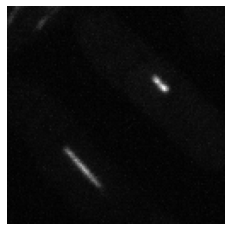

In [177]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\straight_lines_raw\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[9], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))
img = image[9]
plt.imshow(img, cmap="gray");
plt.axis("off");
# 2-4/9, 3-9, 4-2/6, 6-2/3, 7-0
# 8 multiple parallel lines 8-0/1/4

In [183]:
def hough_transform(img): 
    # initialise parameter space of all rhos and thetas
    n_y, n_x = img.shape[:]
    diag = int(np.sqrt(n_x**2 + n_y**2))

    # normalise raw data to fit in [0, 1]
    normalised = (img - np.min(img)) / np.max(img - np.min(img))
    img = normalised 

    # rhos range from -diagnoal to +diagonal of image 
    rhos = np.linspace(-diag, diag, 2*diag+1)
    n_rhos = len(rhos)
    # thetas range from [0, pi] or [-90, 90] radians
    thetas = np.deg2rad(np.linspace(0, 180, 180))
    n_thetas = len(thetas)

    # loop through line pixels 
    ### if image is binarised:
    nonzeros = np.argwhere(img!=0)
    wghts = img[nonzeros[:,0], nonzeros[:,1]] # 16351
    #np.tile(wghts, n_thetas)# 2959531 = 16351*181

    # Hough transform: get rho results 
    x = np.array(nonzeros[:,1])
    y = np.array(nonzeros[:,0])
    n_xys = nonzeros.shape[0]

    theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
    cos_theta_mat = np.cos(theta_mult)
    sin_theta_mat = np.sin(theta_mult)
    rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)

    # get frequency of each (theta, rho) pair 
    # theta == theta_vals and rho == rho_vals 
    accumulator, theta_vals, rho_vals = np.histogram2d(
        np.tile(thetas, rhos_res.shape[0]),
        rhos_res.ravel(), 
        bins = [n_thetas, n_rhos-1], 
        range = [np.deg2rad([0, 180]), [-diag, diag]],
        weights = np.repeat(wghts, n_thetas))
    return accumulator, theta_vals, rho_vals

In [187]:
def conv_via_locmax(accumulator, theta_vals, rho_vals, min_dist):
    # find local maxima 
    if min_len >0: 
        peaks = peak_local_max(accumulator, min_distance = min_dist,
                               exclude_border = False, threshold_abs = min_len)
    else:
        peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False)
    n_peaks = peaks.shape[0]
    print(n_peaks, "peaks:")
    #if n_peaks<10: print(peaks)

    n_x = 128
    xs = np.linspace(0, n_x-1, n_x)
    # get coordinates of line in cartesian coordinates
    rho_peaks = rho_vals[peaks[:,1]]
    theta_peaks = theta_vals[peaks[:,0]]

    cos_theta_peaks = np.cos(theta_peaks)
    sin_theta_peaks = np.sin(theta_peaks)
    # avoid sin(theta = 0) = 0 // can't divide by 0 
    sin_theta_peaks = np.where(sin_theta_peaks == 0, 0.00001, sin_theta_peaks)

    intercept = rho_peaks/sin_theta_peaks
    slope = (-cos_theta_peaks) / sin_theta_peaks
    slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 
    ys = slope_x + intercept
    
    return xs, ys, peaks, [slope, intercept]

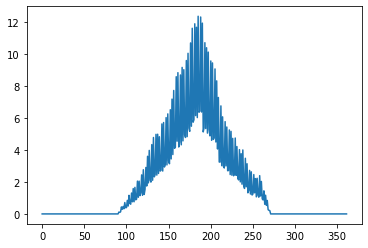

In [13]:
plt.plot(accumulator[135,:]);

3 peaks:


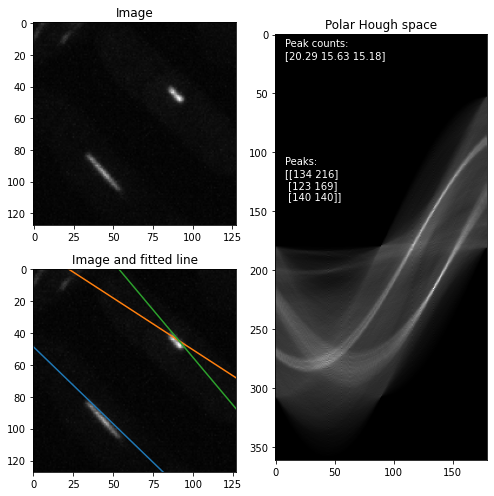

In [188]:
d_min = 20
accumulator, theta_vals, rho_vals = hough_transform(img)
xs, ys, peaks, params = conv_via_locmax(accumulator, theta_vals, rho_vals, d_min)

# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
n_y, n_x = img.shape[:]
x = np.array(range(n_x))
#for i in range(peaks.shape[0]):
#    plt.plot(xs, ys[:,i], c="indianred")
plt.plot(xs, ys)
plt.xlim(0,n_x-1)
plt.ylim(n_y-1,0)
plt.title("Image and fitted line");

fig.add_subplot(122)
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.text(8, 140,("Peaks:\n"+str(peaks)), fontsize = 10, color = "white")
plt.text(8, 20, ("Peak counts:\n"+str(np.around(accumulator[peaks[:,0], peaks[:,1]], 2))),
         fontsize = 10, color = "white")
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\exclude_borders.png", format="png", dpi=600)

- resolved noise from interference at theta 45 and 135...   
- but keep detecting peaks around (176,60)

In [6]:
# ranadom numbers
rng = np.random.default_rng(12345)
rho_r = rng.integers(low=0, high=362, size=1)
theta_r = rng.integers(low=0, high=180, size=1)
#print("rho:   ", rho_r, "\ntheta: ", theta_r)

In [7]:
rho_r = 18.0
theta_r = 124
rho_range = np.tile(rho_r, 7) + np.arange(-3,4)
theta_range = np.tile(theta_r, 7) + np.arange(-3,4)
theta_range = np.deg2rad(theta_range)

NameError: name 'theta_r' is not defined

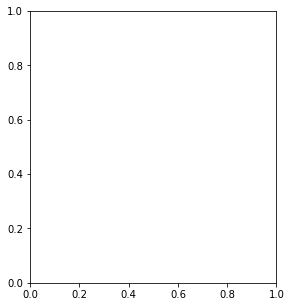

In [181]:
n_x = 128
xs = np.linspace(0, n_x-1, n_x)
# plot image and pixel data side by side
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1,3,1)
# vary rho
cos_theta_r = np.cos(np.deg2rad(theta_r))
sin_theta_r = np.sin(np.deg2rad(theta_r))
intercept = rho_range/sin_theta_r
slope_x = (-cos_theta_r*np.tile(xs.reshape(n_x, 1), 7)) / sin_theta_r 
ys = slope_x + intercept
plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
plt.plot(xs, ys)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Varying rho");

fig.add_subplot(1,3,2)
# vary theta
cos_theta_range = np.cos(theta_range)
sin_theta_range = np.sin(theta_range)
intercept = rho_r/sin_theta_range
slope_x = -cos_theta_range*np.tile(xs.reshape(n_x, 1), 7) / sin_theta_range 
ys = slope_x + intercept
plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
plt.plot(xs, ys)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Varying theta");

fig.add_subplot(1,3,3)
# all varied at once
intercept = rho_range/sin_theta_range
slope = (-cos_theta_range) / sin_theta_range
slope_x = -cos_theta_range*np.tile(xs.reshape(n_x, 1), 7) / sin_theta_range 
ys = slope_x + intercept
plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
plt.plot(xs, ys)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Varying both rho and theta");

In [9]:
# all lines for min_dist = 1
units = np.array([-1,0,1])
rho_r = 18.0
theta_r = 124
rho_range = np.tile(rho_r, 9) + np.repeat(units, 3)
theta_range = np.tile(theta_r, 9) + np.tile(units, 3)

cos_theta_range = np.cos(np.deg2rad(theta_range))
sin_theta_range = np.sin(np.deg2rad(theta_range))
intercept = rho_range/sin_theta_range
slope = (-cos_theta_range) / sin_theta_range
slope_x = (-cos_theta_range)*np.tile(xs.reshape(n_x, 1), 9) / sin_theta_range 
ys = slope_x + intercept

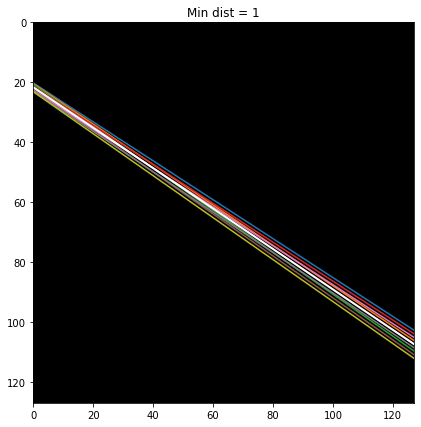

In [10]:
# plot all lines for min_dist = 1
fig = plt.figure(figsize=(7,7))
fig.add_subplot(1,1,1)
plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
plt.plot(xs, ys)
plt.plot(xs, ys[:,4], c = "white", linewidth = 2)
plt.xlim(0,127)
plt.ylim(127,0);
plt.title("Min dist = 1");

In [11]:
units = np.arange(5, 25, step = 5)
n_steps = units.shape[0]
r_theta = np.tile(np.array([-1,1]), 2).reshape(4, 1)*units.reshape(1,n_steps)
r_rho = np.repeat(np.array([-1,1]), 2).reshape(4, 1)*units.reshape(1,n_steps) 

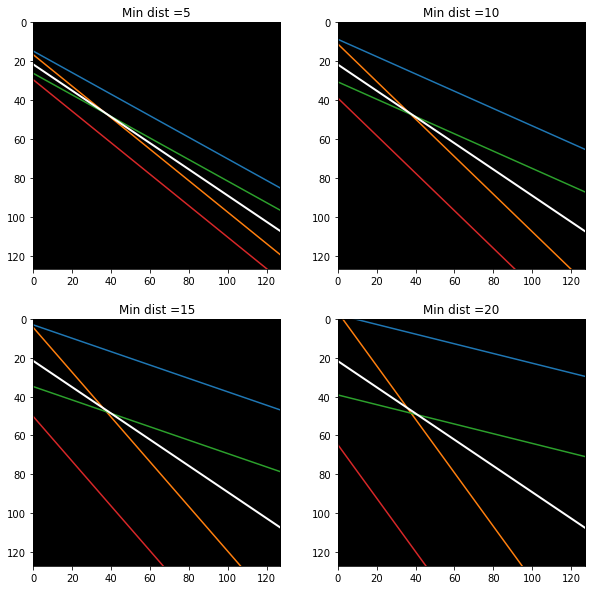

In [12]:
rho_r = 18.0
theta_r = 124
cos_theta_r = np.cos(np.deg2rad(theta_r))
sin_theta_r = np.sin(np.deg2rad(theta_r))
rho_range = np.tile(rho_r, (4,n_steps)) + r_rho
theta_range = np.tile(theta_r, (4,n_steps)) + r_theta
cos_theta_range = np.cos(np.deg2rad(theta_range))
sin_theta_range = np.sin(np.deg2rad(theta_range))

yo = (-cos_theta_r)*xs / sin_theta_r + rho_r/sin_theta_r

fig = plt.figure(figsize=(10,10))
for i in range(n_steps):
    intercept = rho_range[:,i]/sin_theta_range[:,i]
    slope = (-cos_theta_range[:,i]) / sin_theta_range[:,i]
    slope_x = (-cos_theta_range[:,i])*np.tile(xs.reshape(n_x, 1), n_steps) / sin_theta_range[:,i]
    ys = slope_x + intercept
    fig.add_subplot(2,2,i+1)
    plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
    plt.plot(xs, ys)
    plt.plot(xs, yo, c = "white", linewidth = 2)
    plt.xlim(0,127)
    plt.ylim(127,0);
    plt.title(("Min dist ="+str(units[i])));

array([-2.06122726, -3.40260323, 39.16331792, 64.64946143])

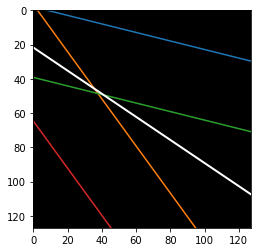

In [13]:
plt.imshow(np.zeros(128*128).reshape((128,128)), cmap="gray")
plt.plot(xs, ys)
plt.plot(xs, yo, c = "white", linewidth = 2)
plt.xlim(0,127)
plt.ylim(127,0);
ys[0,:]

In [158]:
# useabsolute thresholding to curate some of the lines 
def conv_via_locmax(accumulator, theta_vals, rho_vals, min_dist, min_len = 0):
    # find local maxima 
    #peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = True)
    if min_len >0: 
        peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False,
                               threshold_abs = min_len)
    else:
        peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False)
    n_peaks = peaks.shape[0]
    print(n_peaks, "peaks:")
    #if n_peaks<10: print(peaks)

    n_x = 128
    xs = np.linspace(0, n_x-1, n_x)
    # get coordinates of line in cartesian coordinates
    rho_peaks = rho_vals[peaks[:,1]]
    theta_peaks = theta_vals[peaks[:,0]]

    cos_theta_peaks = np.cos(theta_peaks)
    sin_theta_peaks = np.sin(theta_peaks)
    # avoid sin(theta = 0) = 0 // can't divide by 0 
    sin_theta_peaks = np.where(sin_theta_peaks == 0, 0.00001, sin_theta_peaks)

    intercept = rho_peaks/sin_theta_peaks
    slope = (-cos_theta_peaks) / sin_theta_peaks
    slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 
    ys = slope_x + intercept
    
    return xs, ys, peaks, [slope, intercept]

4 peaks:


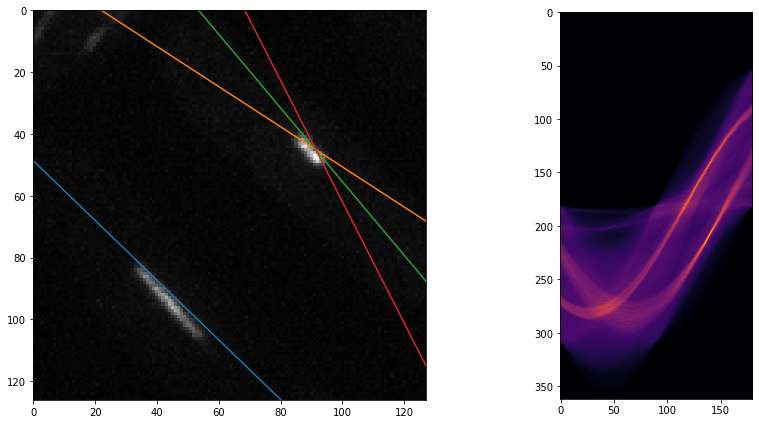

In [199]:
d_min = 10
l_min = 0.5 * np.max(accumulator)
#accumulator, theta_vals, rho_vals = hough_transform(img)
xs, ys, peaks, params = conv_via_locmax(accumulator, theta_vals, rho_vals, d_min)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (12,6))
fig.tight_layout()
ax[0].imshow(img, cmap="gray")
ax[0].plot(xs, ys)
ax[0].set_xlim(0,127)
ax[0].set_ylim(127-1,0);
ax[1].imshow(np.transpose(accumulator), cmap="inferno");
#ax[1].axis("off");

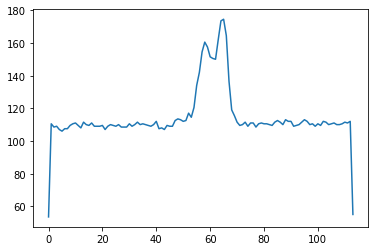

In [200]:
from skimage.measure import profile_line
m = params[0][0]
c = params[1][0]
prof = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
prof = profile[np.nonzero(profile)]
plt.plot(prof);